# Ajuste de gaussianas
Ejercicios de entrenamiento en análisi de espectros gamma 
autor: Fernando Cristancho (lfcristancho@unal.edu.co)

In [10]:
%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams.update({'font.size': 20})

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import NullFormatter


def cm2inch(cm):
    return cm/2.54

def gaussBckgrnd(x,m,s,M,b0,b1):
    z = (m-x)/s
    gauss = M*np.exp(-0.5*z**2)
    fondo = b0 + b1 * (x - m)
    return gauss + fondo

def tandem(x,m1,s1,M1,m2,s2,M2,b0,b1):
    z1 = (m1-x)/s1
    gauss1 = M1*np.exp(-0.5*z1**2)
    z2 = (m2-x)/s2
    gauss2 = M2*np.exp(-0.5*z2**2)
    mm = (m1 + m2)/2
    fondo = b0 + b1 * (x - mm)
    return gauss1 + gauss2 + fondo

def recta(x,b0,b1,x0):
    return b0 + b1 * (x-x0)

def gauss(x,m,s,M):
    z = (m-x)/s
    return M*np.exp(-0.5*z**2)

# toma las salidas de curve_fit: parámetros= pot, matriz de covariaza = pcov
# La diagonal de la matriz de covarianza es la covarianza de cada parámetro. Su raíz cuadrada es la desviación estándar.
def statsGauss_tabla(popt,pcov):
    mu = popt[0] 
    stdv_mu = np.sqrt(pcov[0,0])
    
    s = popt[1]
    s = np.abs(s) # curve_fit puede producir s < 0, sin efecto adverso. 
    stdv_s = np.sqrt(pcov[1,1])
    
    M = popt[2]
    stdv_M = np.sqrt(pcov[2,2])
    
    b0 = popt[3]
    stdv_b0 = np.sqrt(pcov[3,3])
    
    b1 = popt[4]
    stdv_b1 = np.sqrt(pcov[4,4])
    
    I = np.sqrt(2*np.pi)*s*M
    stdv_I = I * np.sqrt((stdv_s/s)**2 + (stdv_M/M)**2) 

    print('   M(c/cnl)      mu(cnl)     sigma(cnl)   I(c) ')
    print('{0:4.2f}({1:2.2f}) &{2:4.1f}({3:2.1f}) &{4:3.1f}({5:2.1f}) &{6:5.0f}({7:3.0f})  \\\\'.format(M,stdv_M,mu,stdv_mu,s,stdv_s,I,stdv_I))
    

En adelante veremos el ajuste a la función
$
f(x)=r(x)+g(x) \\
r(x)=b_0+b_1(\mu-x)\\
g(x)=M\exp\left[ -\frac{1}{2}\left( \frac{\mu-x}{\sigma}\right)^2\right]
$
El primer espectro fue obtenido detectando rayos gamma con un detector NaI (3"x3")

In [11]:
# Lee el archivo con el espectro. Creciórese que escribe correctamente el lugar en el cual está su archivo 22Na.csv
f0 = pd.read_csv('22Na.csv')

In [14]:
x0 = f0['Energia(canal)'].to_numpy()
#x0 = np.arange(0,len(f0['cuentas']))
y0 = f0['cuentas']

Primera gráfica: el espectro entero. Contiene tres picos correspondientes en orden creciente de energía a 511 keV, 1274 keV y el pico suma de las dos anteriores energías.

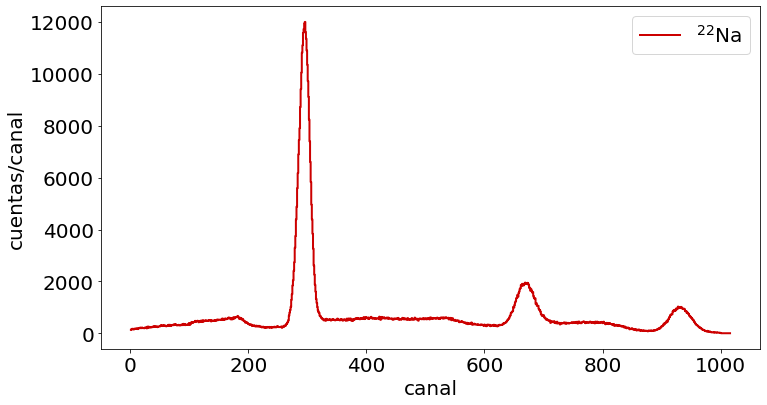

In [15]:
fig, ax = plt.subplots(1,1,figsize=(cm2inch(30.0),cm2inch(16.0)))
plt.plot(x0,y0,drawstyle='steps-mid',linewidth=2,color=(0.8,0,0,1),label=r'$^{22}$Na')
ax.set_xlabel('canal')
ax.set_ylabel('cuentas/canal')
plt.legend()

Ahora vamos a tomar solamente la parte del espectro que contiene el pico de más alta energía...

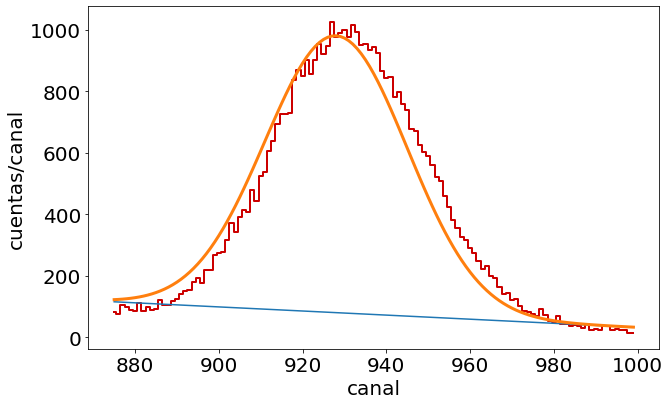

In [5]:
x=x0[875:1000]
y=y0[875:1000]
fig, ax =plt.subplots(1,1,figsize=(cm2inch(26.0),cm2inch(16.0)))
ax.plot(x,y,drawstyle='steps-mid',linewidth=2,color=(0.8,0,0,1))
# siguientes líneas: inicialización de los parámetros de ajuste
mu = 928
s = 17
M = 901
b0 = 80
b1 = -80/120
rf = recta(x,b0,b1,mu)
plt.plot(x,rf)
gf = gaussBckgrnd(x,mu,s,M,b0,b1)
ax.plot(x,gf,lw=3); # Miramos qué tan buenos son los parámetros graficando con ellos (sin ajustar todavía)
ax.set_xlabel('canal')
ax.set_ylabel('cuentas/canal');

In [6]:
# Evaluación de la pendiente de la línea  recta, b1:
(0-100)/(1000-875)

-0.8

"Empaquetamos" los parámetros iniciales en el arreglo 'p0' y pedimos el ajuste.

In [7]:
p0 = np.array([mu,s,M,b0,b1])
popt, pcov = curve_fit(gaussBckgrnd,x,y,p0,sigma=np.sqrt(y))

"Desempaquetamos" los parámetros resultantes para usarlos en la producción de la curva ajustada 'y_fit' 

   M(c/cnl)      mu(cnl)     sigma(cnl)   I(c) 
941.83(6.13) &931.1(0.1) &17.9(0.1) &42287(382)  \\


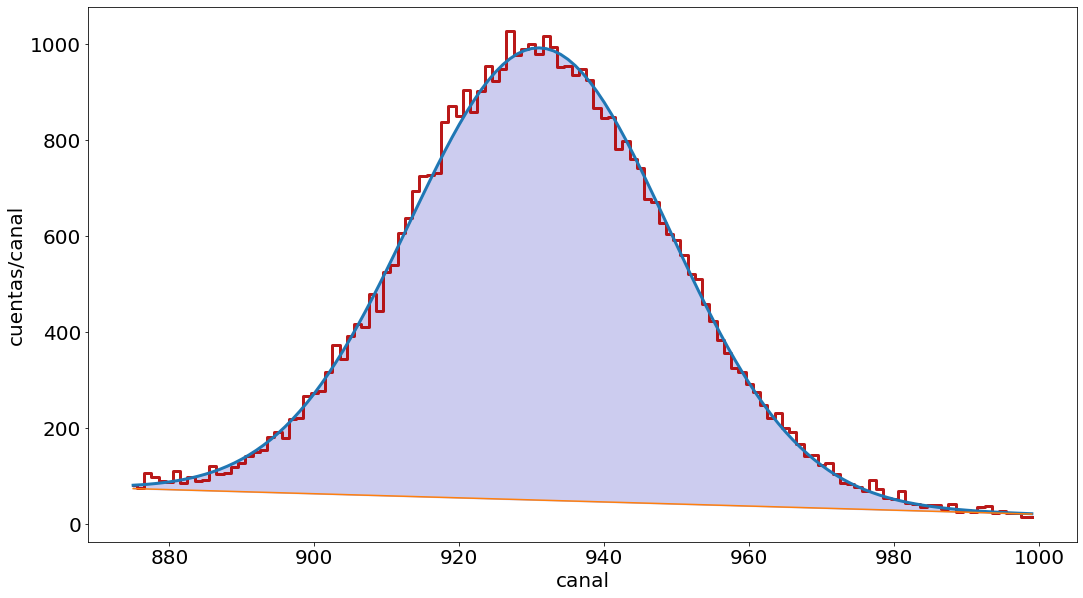

In [8]:
mu,s,M,b0,b1 = popt
y_fit = gaussBckgrnd(x,mu,s,M,b0,b1)
r_fit = recta(x,b0,b1,mu)
fig, ax = plt.subplots(1,1,figsize=(cm2inch(45.0),cm2inch(25.0)))
ax.plot(x,y,drawstyle='steps-mid',linewidth=3,color=(0.7,0,0,0.9))
ax.plot(x,y_fit,lw=3)
ax.plot(x,r_fit)
ax.fill_between(x,r_fit,y_fit,color=(0,0,0.7,0.2))
ax.set_xlabel('canal')
ax.set_ylabel('cuentas/canal')
statsGauss_tabla(popt,pcov) # La salida produce resultados listos para incluir y editar en latex. Pero falta depurar la notación de las incertidumbres...

A veces ajustamos picos para averiguar cuál es su integral. En muchas ocasiones "no tenemos la más peregrina idea" de cuánto podría resultar para la integral. El siguiente es un método que uso para evaluar si el software o yo estamos haciendo algo mal. Evalúo la integral de la gaussiana aproximándola a un triángulo:

área de un triángulo = base*altura/2 

base = 6*$\sigma$

altura  = $M$

$
I \approx (6\sigma) \times M / 2 = 3\sigma M
$

In [9]:
3*s*M

50610.55091150505